# Sync

In [1]:
# from IPython import display
import requests
from lxml import html
from lxml.etree import XPathEvalError
import pandas as pd
from configparser import ConfigParser

config = ConfigParser()
config.read('config.ini')
email = config['login']['email']
password = config['login']['password']

pd.set_option('display.max_rows', 100)

df = pd.DataFrame()

url = 'https://profitus.lt/users/login'

resp = ''

from time import time
current_time = time()

with requests.session() as client:
  client.get(url)
  csrftoken = client.cookies['csrfToken']
  login_data = dict(email=email, password=password, _csrfToken=csrftoken, next='/')
  r = client.post(url, data=login_data, headers=dict(Referer=url))
  resp = client.get('https://www.profitus.lt/secondary-market') # ?page=5
  tree = html.fromstring(resp.text)
  next_url = 'https://profitus.lt' + tree.xpath('//a[@class="page-link-p fw-700"]')[0].values()[0]

  df = pd.read_html(resp.text)[0]
  try:
    while next_url:
      b = 2
      resp = client.get(next_url)
      print(resp.url)
      tree = html.fromstring(resp.text)
      next_url = 'https://profitus.lt' + tree.xpath('//a[@class="page-link-p fw-700"]')[b].values()[0]
      # df.merge(pd.read_html(resp.text)[0])
      df = pd.concat((df, pd.read_html(resp.text)[0]))
      if len(tree.xpath('//a[@class="page-link-p fw-700"]')) == 4:
        b = 2
      else:
        raise XPathEvalError('XPath was not found | scraping ended.')
  except (XPathEvalError, IndexError):
      print('scraping is over!')
  # print(df.columns)
  
print("Time taken: ", time() - current_time)

df = df.drop(['Unnamed: 0', 'Unnamed: 9'], axis=1)

df['Projekto pavadinimas'] = df['Projekto pavadinimas'].map(lambda x: x.lstrip('Projekto pavadinimas:&nbsp '))
df['Reitingas'] = df['Reitingas'].map(lambda x: x.lstrip('Reitingas:&nbsp '))
df['Likęs terminas'] = df['Likęs terminas'].map(lambda x: x.lstrip('Likęs terminas:&nbsp ').rstrip('mėn.'))

df['Likęs terminas'] = df['Likęs terminas'].map(lambda x: x.split('/')[0]).astype(int) + 1 # 1 month and 29 days is considered as 1 month, we're calculating worst example possible. only those will be worth to buy


df['Likusi suma'] = df['Likusi suma'].map(lambda x: x.lstrip('Likusi suma:&nbsp'))

df['Likusi suma'] = df['Likusi suma'].str.replace('€', '')
df['Likusi suma'] = df['Likusi suma'].str.replace(',', '').astype(float)

df['Palūkanų norma'] = df['Palūkanų norma'].map(lambda x: x.lstrip('Palūkanų norma:&nbsp'))

df['Palūkanų norma'] = df['Palūkanų norma'].str.replace('%', '').astype(float)


df['Statusas'] = df['Statusas'].map(lambda x: x.lstrip('Statusas:&nbsp'))

df['Statusas'] = df['Statusas'].str.replace('Aktyvus', '1')
df['Statusas'] = df['Statusas'].str.replace('Vėluoja', '2').astype(int)



df['Likusi gautina sumai'] = df['Likusi gautina sumai'].map(lambda x: x.lstrip('Likusi gautina suma:&nbsp '))

df['Likusi gautina sumai'] = df['Likusi gautina sumai'].str.replace('€', '')
df['Likusi gautina sumai'] = df['Likusi gautina sumai'].str.replace(',', '').astype(float)

df['Pardavimo kaina'] = df['Pardavimo kaina'].map(lambda x: x.lstrip('Pardavimo kaina:&nbsp '))

df['Pardavimo kaina'] = df['Pardavimo kaina'].str.replace('€', '')
df['Pardavimo kaina'] = df['Pardavimo kaina'].str.replace(',', '').astype(float)

df['Realios palūkanos'] = (df['Likusi gautina sumai'] - df['Pardavimo kaina']) * 100 / df['Pardavimo kaina'] / (df['Likęs terminas']/12)
print(df[(df['Palūkanų norma'] - df['Realios palūkanos']) < 0]) # basically we're trying to find projects that have largest interest rate, than
df.sort_values('Realios palūkanos', ascending=False).head(100)

https://profitus.lt/secondary-market?page=2
https://profitus.lt/secondary-market?page=3
https://profitus.lt/secondary-market?page=4
https://profitus.lt/secondary-market?page=5
https://profitus.lt/secondary-market?page=6
https://profitus.lt/secondary-market?page=7
https://profitus.lt/secondary-market?page=8
https://profitus.lt/secondary-market?page=9
https://profitus.lt/secondary-market?page=10
scraping is over!
Time taken:  6.798128604888916
Empty DataFrame
Columns: [Projekto pavadinimas, Reitingas, Likęs terminas, Likusi suma, Palūkanų norma, Statusas, Likusi gautina sumai, Pardavimo kaina, Realios palūkanos]
Index: []


,Projekto pavadinimas,Reitingas,Likęs terminas,Likusi suma,Palūkanų norma,Statusas,Likusi gautina sumai,Pardavimo kaina,Realios palūkanos
4,#403 Bendorių panoramos,C,11,200.00,8.0,1,215.91,205.0,5.805765
2,#400 Du dvibučiai Didžiojoje Riešėje II,C+,11,120.37,7.5,1,129.35,123.0,5.631929
0,#411 Antakalnio vakarai,D,11,570.25,12.0,1,638.31,610.0,5.062891
1,#274 Namas Kulmo g.,B-,7,1500.00,9.0,1,1593.58,1550.0,4.819908
3,#372 Gyvenamasis namas Panevėžyje,B-,9,109.24,7.0,1,116.84,113.0,4.530973
4,#373 Butas Pilies g.,A-,9,100.00,6.0,1,105.97,102.5,4.513821
2,#357 Namas Antakalnyje,C+,8,216.49,8.0,2,228.59,222.0,4.452703
4,#411 Antakalnio vakarai,D,11,6050.00,13.0,1,6832.19,6580.0,4.181100
1,"#404 Kvartalas „Baltai"" II",B-,11,1915.90,9.5,1,2096.91,2020.0,4.153555
4,#428 Namai Bališkių pušyne,B-,12,1219.63,8.5,1,1322.73,1270.0,4.151969


# Async

In [1]:
# from IPython import display
import grequests
import requests
from lxml import html
import pandas as pd
import re
from configparser import ConfigParser

config = ConfigParser()
config.read('config.ini')
email = config['login']['email']
password = config['login']['password']


pd.set_option('display.max_rows', 100)

df = pd.DataFrame()

url = 'https://profitus.lt/users/login'

resp = ''

login_data = {}

def get_data():
  urls = []
  with requests.session() as client:
    client.get(url)
    csrftoken = client.cookies['csrfToken']
    login_data = dict(email=email, password=password, _csrfToken=csrftoken, next='/')
    r = client.post(url, data=login_data, headers=dict(Referer=url))
    resp = client.get('https://www.profitus.lt/secondary-market')
    tree = html.fromstring(resp.text)
    next_url = 'https://profitus.lt' + tree.xpath('//a[@class="page-link-p fw-700"]')[-1].values()[0]

    number_of_pages = int(re.search("\d+", next_url).group())

    for i in range(1, number_of_pages+1):
      urls.append(f'https://www.profitus.lt/secondary-market?page={i}')
      
    reqs = [grequests.get(link, headers=dict(Referer=url), session=client) for link in urls]
    resp = grequests.map(reqs)
    return resp

def parse_data(resp):
  global df
  for r in resp:
    print(r.url)
    df = pd.concat([df, pd.read_html(r.text)[0]])

  print('scraping is over!')


from time import time

current_time = time()

resp = get_data()
parse_data(resp)

print("Time taken: ", time() - current_time)

df = df.drop(['Unnamed: 0', 'Unnamed: 9'], axis=1)

df['Projekto pavadinimas'] = df['Projekto pavadinimas'].map(lambda x: x.lstrip('Projekto pavadinimas:&nbsp '))
df['Reitingas'] = df['Reitingas'].map(lambda x: x.lstrip('Reitingas:&nbsp '))
df['Likęs terminas'] = df['Likęs terminas'].map(lambda x: x.lstrip('Likęs terminas:&nbsp ').rstrip('mėn.'))

df['Likęs terminas'] = df['Likęs terminas'].map(lambda x: x.split('/')[0]).astype(int) + 1 # 1 month and 29 days is considered as 1 month, we're calculating worst example possible. only those will be worth to buy


df['Likusi suma'] = df['Likusi suma'].map(lambda x: x.lstrip('Likusi suma:&nbsp'))

df['Likusi suma'] = df['Likusi suma'].str.replace('€', '')
df['Likusi suma'] = df['Likusi suma'].str.replace(',', '').astype(float)

df['Palūkanų norma'] = df['Palūkanų norma'].map(lambda x: x.lstrip('Palūkanų norma:&nbsp'))

df['Palūkanų norma'] = df['Palūkanų norma'].str.replace('%', '').astype(float)


df['Statusas'] = df['Statusas'].map(lambda x: x.lstrip('Statusas:&nbsp'))

df['Statusas'] = df['Statusas'].str.replace('Aktyvus', '1')
df['Statusas'] = df['Statusas'].str.replace('Vėluoja', '2').astype(int)



df['Likusi gautina sumai'] = df['Likusi gautina sumai'].map(lambda x: x.lstrip('Likusi gautina suma:&nbsp '))

df['Likusi gautina sumai'] = df['Likusi gautina sumai'].str.replace('€', '')
df['Likusi gautina sumai'] = df['Likusi gautina sumai'].str.replace(',', '').astype(float)

df['Pardavimo kaina'] = df['Pardavimo kaina'].map(lambda x: x.lstrip('Pardavimo kaina:&nbsp '))

df['Pardavimo kaina'] = df['Pardavimo kaina'].str.replace('€', '')
df['Pardavimo kaina'] = df['Pardavimo kaina'].str.replace(',', '').astype(float)

df['Realios palūkanos'] = (df['Likusi gautina sumai'] - df['Pardavimo kaina']) * 100 / df['Pardavimo kaina'] / (df['Likęs terminas']/12)
print(df[(df['Palūkanų norma'] - df['Realios palūkanos']) < 0]) # basically we're trying to find projects that have largest interest rate, than
df.sort_values('Realios palūkanos', ascending=False).head(100)

https://www.profitus.lt/secondary-market?page=1
https://www.profitus.lt/secondary-market?page=2
https://www.profitus.lt/secondary-market?page=3
https://www.profitus.lt/secondary-market?page=4
https://www.profitus.lt/secondary-market?page=5
https://www.profitus.lt/secondary-market?page=6
https://www.profitus.lt/secondary-market?page=7
https://www.profitus.lt/secondary-market?page=8
https://www.profitus.lt/secondary-market?page=9
scraping is over!
Time taken:  2.9670822620391846
Empty DataFrame
Columns: [Projekto pavadinimas, Reitingas, Likęs terminas, Likusi suma, Palūkanų norma, Statusas, Likusi gautina sumai, Pardavimo kaina, Realios palūkanos]
Index: []


,Projekto pavadinimas,Reitingas,Likęs terminas,Likusi suma,Palūkanų norma,Statusas,Likusi gautina sumai,Pardavimo kaina,Realios palūkanos
2,#411 Antakalnio vakarai,D,11,200.00,12.0,1,223.87,208.00,8.323427
5,#395 Saurenta plėtra,C+,10,530.00,8.5,1,574.80,545.00,6.561468
0,#396 Lapino namai IV,B-,10,505.00,8.0,1,545.18,520.00,5.810769
5,#400 Du dvibučiai Didžiojoje Riešėje II,C+,11,120.37,7.5,1,129.35,123.00,5.631929
0,#347 Užupio butai,B,7,100.00,8.0,2,105.35,102.00,5.630252
3,#443 Sklypas Žeimenos g.,C,12,500.00,9.0,1,544.75,516.00,5.571705
4,#411 Antakalnio vakarai,D,11,500.00,12.0,1,559.67,535.00,5.030416
4,#402 Tarandės namai II,B+,16,200.00,6.5,1,218.31,205.00,4.869512
3,#421 Butas Pylimo g.,B+,8,100.00,7.0,1,105.22,102.04,4.674637
4,#442 Naujakurių daugiabutis Kaune,C+,18,1338.64,8.5,1,1508.54,1410.00,4.659102


C:\Users\adoma\AppData\Local\Programs\Python\Python39\lib\site-packages\gevent\hub.py:161: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [5]:
print(df[(df['Palūkanų norma'] - df['Realios palūkanos']) < 0]) # basically we're trying to find projects that have largest interest rate, than


Empty DataFrame
Columns: [Projekto pavadinimas, Reitingas, Likęs terminas, Likusi suma, Palūkanų norma, Statusas, Likusi gautina sumai, Pardavimo kaina, Realios palūkanos]
Index: []


In [4]:
df[df['Realios palūkanos'] < 0]

,Projekto pavadinimas,Reitingas,Likęs terminas,Likusi suma,Palūkanų norma,Statusas,Likusi gautina sumai,Pardavimo kaina,Realios palūkanos
3,#337 Valakampių apartamentai,C+,8,100.0,8.0,2,105.59,115.0,-12.273913
4,#322 Namas Žemuogių g.,C,6,110.0,8.5,2,114.33,115.0,-1.165217
1,"#343 Namų kvartalas „Baltai sala""",C-,8,350.0,9.0,1,373.04,375.0,-0.784000
3,#400 Du dvibučiai Didžiojoje Riešėje II,C+,11,500.0,8.0,1,539.78,544.0,-0.846257
1,#394 Mėtų dvibutis,C,5,100.0,8.5,1,104.19,105.0,-1.851429


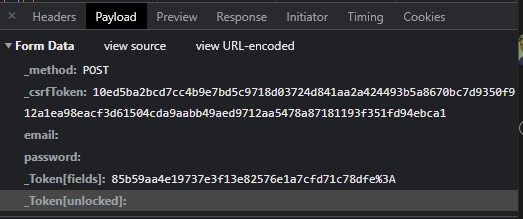


In [ ]:
from datetime import datetime

date = datetime.now().strftime('%Y-%m-%d')

df.sort_values('Realios palūkanos', ascending=False).head(100).to_excel(f'profitus_secondary_market_{date}.xlsx')